<a href="https://colab.research.google.com/github/yoouza/bigcontest/blob/master/data_analysis/Various_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기
- 서울에 해당하는 중구(140), 노원구(350)를 사용합니다.
- 다음의 카테고리(MCT_CAT_CD) 별로 모델을 학습하기 위해 총 9가지로 데이터를 분리합니다.

#### 온라인 서비스
1. 가구(30), 주방용구(32)
2. 가전(35), 사무통신(52)
3. 레저용품(20)
4. 신변잡화(44)
5. 음료식품(81)
6. 의복(42)
#### 오프라인 서비스
7. 숙박(10)
8. 유통업(40)
9. 요식업소(80)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import gc
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from google.colab import drive
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
# drive.mount('/content/drive')

# 그래프 한글 출력 설정
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') 

data = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_RESIDENT.csv', sep='\t')
data_foreigner = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_FOREIGNER.txt', sep='\t', encoding='cp949')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 국내
jung = data[data.GU_CD == 140].reset_index(drop = True)
nowon = data[data.GU_CD == 350].reset_index(drop = True)

seoul = pd.concat([jung, nowon])
seoul['STD_DD'] = seoul.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
seoul2019 = seoul[seoul.STD_DD < '2020-01-01']
seoul2020 = seoul[seoul.STD_DD > '2020-01-01']

In [4]:
# 외국인
jung_foreigner = data_foreigner[data_foreigner.GU_CD == 140].reset_index(drop = True)
nowon_foreigner = data_foreigner[data_foreigner.GU_CD == 350].reset_index(drop = True)

foreigner = pd.concat([jung_foreigner, nowon_foreigner])
foreigner['STD_DD'] = foreigner.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
foreigner2019 = foreigner[foreigner.STD_DD < '2020-01-01']
foreigner2020 = foreigner[foreigner.STD_DD > '2020-01-01']

In [5]:
# 국내 + 외국인 합치기
def indexing(df):
    return df.groupby(['STD_DD', 'MCT_CAT_CD'])[['USE_CNT', 'USE_AMT']].sum()

def sum_korean_foreigner(df_korean, df_foreigner):
    df_foreigner.columns = ['USE_CNT2', 'USE_AMT2']
    df_all = pd.concat([df_korean, df_foreigner], axis=1)
    df_all['USE_CNT_SUM'] = np.nansum([df_all['USE_CNT'], df_all['USE_CNT2']], axis=0)
    df_all['USE_AMT_SUM'] = np.nansum([df_all['USE_AMT'], df_all['USE_AMT2']], axis=0)
    df_all = df_all[['USE_CNT_SUM', 'USE_AMT_SUM']]
    df_all.columns = ['USE_CNT', 'USE_AMT']
    return df_all.reset_index()

seoul2019 = indexing(seoul2019)
seoul2020 = indexing(seoul2020)
foreigner2019 = indexing(foreigner2019)
foreigner2020 = indexing(foreigner2020)

df_2019 = sum_korean_foreigner(seoul2019, foreigner2019)
df_2020 = sum_korean_foreigner(seoul2020, foreigner2020)

# 변수 추가하기
1. 전국 코로나 신규 확진자 수
2. 사회/경제 뉴스
3. 날짜 변수

In [6]:
# 코로나
covid = pd.read_csv('/content/drive/My Drive/COVID-19_TimeProvince.csv')
covid = covid.groupby('date').sum().reset_index()
covid['date'] = covid.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid = covid[covid.date < '2020-06-01'][covid.date >= '2020-01-31']
covid = covid.rename(columns = {'date': 'STD_DD'})
covid['covid'] = 0
covid['covid'][1:] = covid['confirmed'].values[1:] - covid['confirmed'][:-1].values
covid = covid[1:]
df_2020 = pd.merge(df_2020, covid[['STD_DD', 'covid']])
df_2019['covid'] = 0

In [7]:
# 뉴스
news = pd.read_csv('/content/drive/My Drive/news_predict_new.csv')
news['STD_DD'] = news['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
news['STD_DD'] = news['STD_DD'] - timedelta(days = 7)

# Preprocessing 함수 정의
- Test set: 5월 마지막 주
- rolling window 적용하기

In [30]:
# 7일 동안의 데이터를 바탕으로 다음 일주일 매출을 예측 (rolling window)
def preprocessing(df):
    amt_X, amt_y = [], []
    cnt_X, covid_X, news_X = [], [], []

    for i in range(len(df)-14+1):
        # 사용하는 feature 값
        amt_X.append(df.USE_AMT[i:i+7].values)
        cnt_X.append(df.USE_CNT[i:i+7].values)
        covid_X.append(df.covid[i:i+7].values)
        news_X.append(df.news[i:i+7].values)
        # 예측값
        amt_y.append(df.USE_AMT[i+7:i+14].values)

    amt_X = np.array(amt_X)
    cnt_X = np.array(cnt_X)
    covid_X = np.array(covid_X)
    news_X = np.array(news_X)

    amt_y = np.array(amt_y)

    X = np.concatenate([amt_X.reshape(-1, 7, 1), cnt_X.reshape(-1, 7, 1), covid_X.reshape(-1, 7, 1), news_X.reshape(-1, 7, 1)], axis=2)
    y = amt_y

    return X, y

In [9]:
# 카테고리 번호로 데이터 뽑아내기
def set_category(df, category_num):
    return df[df.MCT_CAT_CD == category_num].groupby('STD_DD').sum().drop('MCT_CAT_CD', axis=1).reset_index()

- 카테고리가 2개 이상인 것들 먼저 저장

In [10]:
df = []
df2 = []

# 1. 가구, 주방용구
# 2019
tmp1 = set_category(df_2019, 30)
tmp2 = set_category(df_2019, 32)
tmp2.loc[4] = [datetime.strptime('2019-02-05', '%Y-%m-%d'), 0, 0, 0] # 2019-02-05 결측값이 있어서 채워줌
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '30_32']]).rename(columns = {'30_32': 'news'})
df.append(tmp1)
# 2020
tmp1 = set_category(df_2020, 30)
tmp2 = set_category(df_2020, 32)
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '30_32']]).rename(columns = {'30_32': 'news'})
df2.append(tmp1)

# 2. 가전, 사무통신
# 2019
tmp1 = set_category(df_2019, 35)
tmp2 = set_category(df_2019, 52)
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '35_52']]).rename(columns = {'35_52': 'news'})
df.append(tmp1)
# 2020
tmp1 = set_category(df_2020, 35)
tmp2 = set_category(df_2020, 52)
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '35_52']]).rename(columns = {'35_52': 'news'})
df2.append(tmp1)

- 그 외 카테고리 1개인 것들 저장

In [11]:
n_categories = [10, 20, 40, 42, 44, 80, 81]

for n_category in n_categories:
    # 2019
    tmp = set_category(df_2019, n_category)
    tmp = pd.merge(tmp, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})
    df.append(tmp)

    # 2020
    tmp2 = set_category(df_2020, n_category)
    tmp2 = pd.merge(tmp2, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})
    df2.append(tmp2)

# 1. XGBoost

### Train
Grid Search CV 이용해서 최적의 Parameter 찾기

In [68]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

param_grid = {'estimator__min_samples_split':[10, 50],
              'estimator__min_samples_leaf':[50, 150],
              'estimator__max_depth': [5, 6, 7, 8, 9, 10]}

# xgb_cv = []
xgb_pred = []
xgb_score = []
train_y, test_y = [], []

for i in tqdm(range(9)):
    X, y = preprocessing(df[i])
    X2, y2 = preprocessing(df2[i])

    # 2019, 2020 합치기
    X = np.concatenate([X, X2])
    y = np.concatenate([y, y2])

    # XGBoost는 3차원을 인식 못하므로 2차원으로 펴주는 과정 필요
    X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]
    X_train = X_train.reshape(len(X_train), -1) 
    X_test = X_test.reshape(len(X_test), -1)

    train_y.append(y_train[-1]) # 5/17 ~ 5/24
    test_y.append(y_test[-1]) # 5/25 ~ 5/31

    gb = xgb.XGBRegressor(objective='reg:squarederror')
    gs = GridSearchCV(MultiOutputRegressor(gb), param_grid=param_grid, cv = 3)
    gs.fit(X_train, y_train)

    gs_xgb = gs.best_estimator_
    gs_xgb.fit(X_train, y_train)

    # kf = KFold(n_splits = 5)
    # scores = []
    # for train_index, test_index in kf.split(X_train):
    #     gs_xgb = gs.best_estimator_
    #     gs_xgb.fit(X_train[train_index], y_train[train_index])
    #     pred = gs_xgb.predict(X_train[test_index])
    #     scores.append(mean_absolute_percentage_error(y_train[test_index], pred))

    y_pred = gs_xgb.predict(X_test)
    xgb_pred.append(y_pred[-1]) # 각 카테고리의 Prediction 값(마지막 주)
    xgb_score.append(mean_absolute_percentage_error(y_test, y_pred)) # 각 카테고리의 Test Score
    # xgb_cv.append(np.mean(scores))
    
    del gb, gs, gs_xgb
    gc.collect()

100%|██████████| 9/9 [04:59<00:00, 33.28s/it]


### Prediction
- 각 카테고리 예상 매출의 MAPE(Mean Squared Percentage Error)값

In [72]:
xgb_score

[29.65366287422182,
 13.287071239111201,
 19.473656166239582,
 25.60262894763637,
 13.342097805857659,
 25.016994406477743,
 28.09426627642711,
 10.517795251032844,
 23.934881238064516]

### 시각화

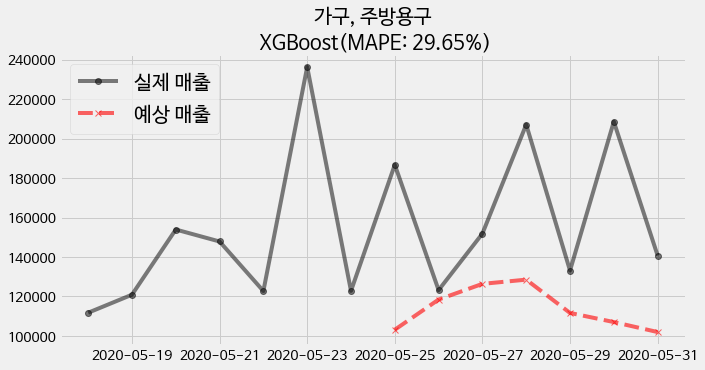

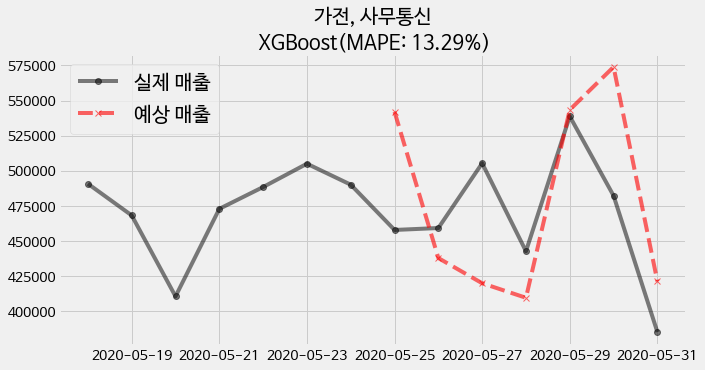

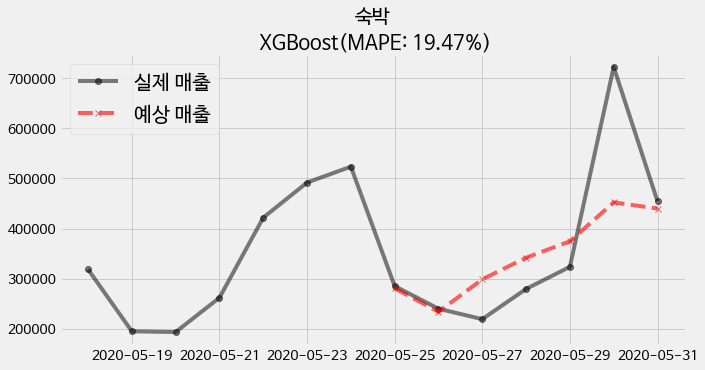

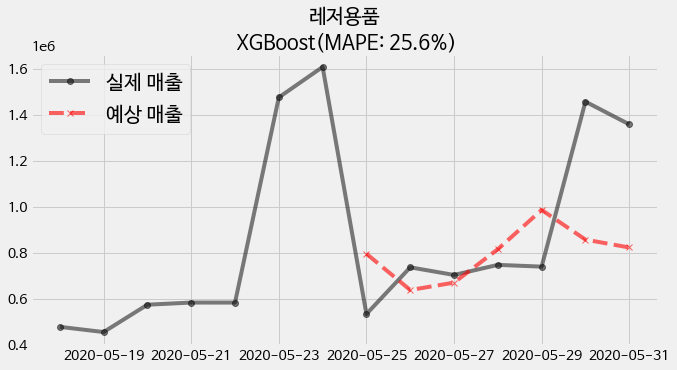

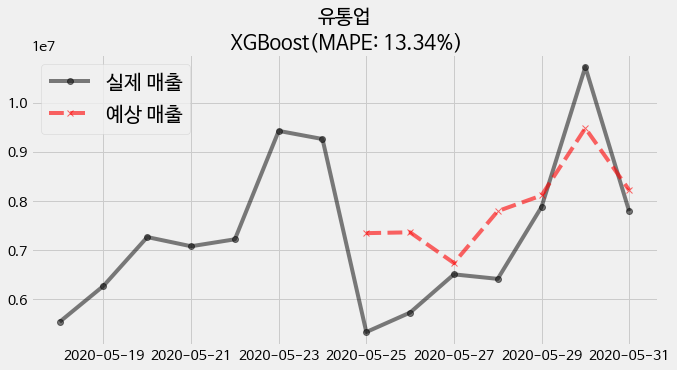

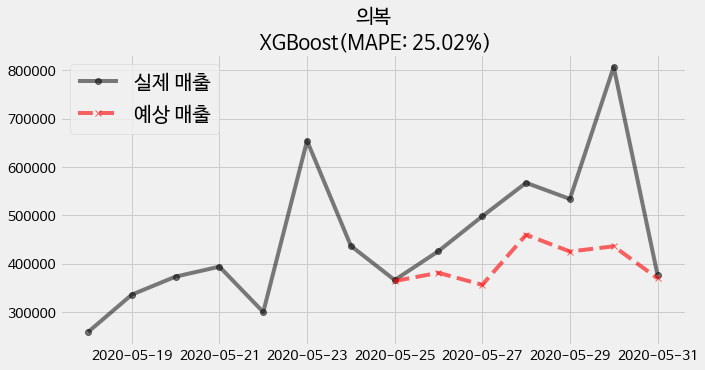

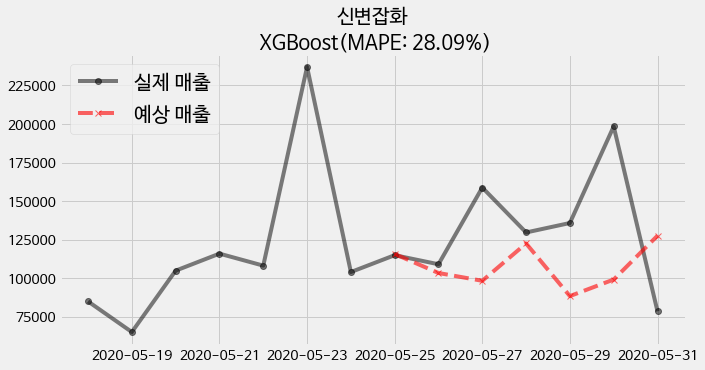

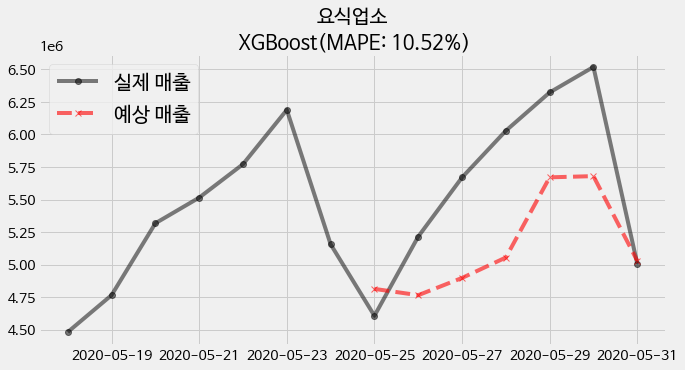

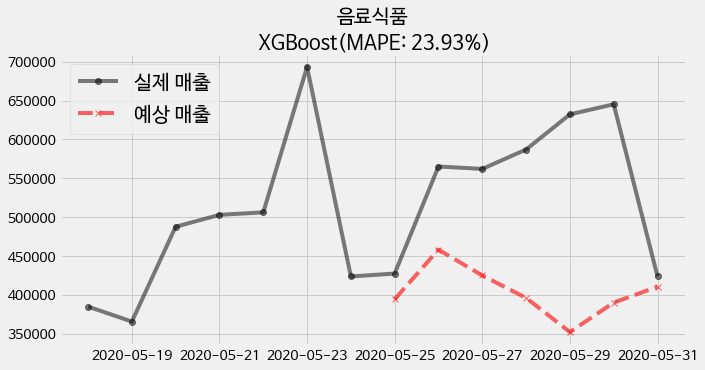

In [89]:
dates = covid.STD_DD.values[-14:]
names = ['가구, 주방용구', '가전, 사무통신', '숙박', '레저용품', '유통업', '의복', '신변잡화', '요식업소', '음료식품']

for i in range(9):
    # 5/17 ~ 5/31의 실제 매출
    real_amt = list(train_y[i]) + list(test_y[i]) 
    # 5/25 ~ 5/31 예상 매출
    pred_amt = xgb_pred[i]

    plt.figure(figsize=(10,5))
    plt.plot(dates, real_amt, marker = 'o', color = 'black', label = '실제 매출', alpha = 0.5)
    plt.plot(dates[7:], pred_amt, color = 'red', label = '예상 매출', marker = 'x', ls = '--', alpha = 0.6)
    plt.legend(loc = 'upper left', fontsize = 'x-large')
    plt.title(f"{names[i]}\n XGBoost(MAPE: {round(xgb_score[i], 2)}%)", size = 20)
    plt.show()

# 2. LSTM

### Train

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTMModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size):
        # time model
        super(LSTMModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # merge model
        self.time_fc = nn.Sequential(
            nn.Linear(hidden_size, 14),
            nn.ReLU(inplace=True),
            nn.Linear(14,14),
            nn.ReLU(inplace=True),
            nn.Linear(14,7)
        )
        
    def forward(self, x_time):
        # time part
        hidden = (
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        )
        
        out, _ = self.lstm(x_time, hidden)
        out = out[:, -1, :] # LSTM의 output은 모든 출력값인데 마지막 값만 받는다.
        out = self.time_fc(out.view(-1, self.hidden_size)) # 3 -> 2차원
        
        return out

In [118]:
cols = list(df[0].columns[1:])
lstm_pred = []
lstm_score = []
train_y, test_y = [], []

for i in tqdm(range(9)):
    # 정규화
    for col in cols:
        if col != 'news':
            scaler = MinMaxScaler(feature_range = (0, 1))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2
        else:
            scaler = MinMaxScaler(feature_range = (-0.5, 0.5))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2

    X, y = preprocessing(df[i])
    X2, y2 = preprocessing(df2[i])

    # 2019, 2020 합치기
    X = np.concatenate([X, X2])
    y = np.concatenate([y, y2])

    X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]

    train_y.append(y_train[-1]) # 5/17 ~ 5/24
    test_y.append(y_test[-1]) # 5/25 ~ 5/31

    X = torch.FloatTensor(X_train).to(device)
    y = torch.FloatTensor(y_train).to(device)

    # hidden state : 전달과정 중간 출력의 차원
    model_trend = LSTMModel_trend(input_size = 4, hidden_size = 32).to(device)
    optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
    criterion = nn.MSELoss(size_average = True)

    # Train model
    num_epochs  = 200
    hist = np.zeros(num_epochs)

    # Number of steps to unroll
    look_back = 7
    seq_dim =look_back - 1

    for t in range(num_epochs):
        pred = model_trend(X)
        loss = criterion(pred, y)

        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_pred = model_trend(torch.FloatTensor(X_test).to(device))
    lstm_pred.append(y_pred[-1].cpu().detach().numpy()) # 각 카테고리의 Prediction 값(마지막 주)
    lstm_score.append(mean_absolute_percentage_error(y_test, y_pred.cpu().detach().numpy())) # 각 카테고리의 Test Score

    del X, y
    gc.collect()


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch  10 MSE:  0.0626952275633812
Epoch  20 MSE:  0.03918388485908508
Epoch  30 MSE:  0.03456757217645645
Epoch  40 MSE:  0.030114011839032173
Epoch  50 MSE:  0.02884959988296032
Epoch  60 MSE:  0.02833101525902748
Epoch  70 MSE:  0.028093116357922554
Epoch  80 MSE:  0.027902336791157722
Epoch  90 MSE:  0.027759544551372528
Epoch  100 MSE:  0.027622902765870094
Epoch  110 MSE:  0.027512352913618088
Epoch  120 MSE:  0.02741646021604538
Epoch  130 MSE:  0.02726399339735508
Epoch  140 MSE:  0.027113277465105057
Epoch  150 MSE:  0.02683679386973381
Epoch  160 MSE:  0.02644813247025013
Epoch  170 MSE:  0.02581888437271118
Epoch  180 MSE:  0.02543034590780735
Epoch  190 MSE:  0.024775618687272072



 11%|█         | 1/9 [00:00<00:06,  1.21it/s]

Epoch  10 MSE:  0.03657829388976097
Epoch  20 MSE:  0.03261588141322136
Epoch  30 MSE:  0.02621947042644024
Epoch  40 MSE:  0.021435193717479706
Epoch  50 MSE:  0.019615788012742996
Epoch  60 MSE:  0.01821311004459858
Epoch  70 MSE:  0.017435118556022644
Epoch  80 MSE:  0.01709545962512493
Epoch  90 MSE:  0.016835620626807213
Epoch  100 MSE:  0.016648953780531883
Epoch  110 MSE:  0.01640361361205578
Epoch  120 MSE:  0.016068272292613983
Epoch  130 MSE:  0.015608580783009529
Epoch  140 MSE:  0.015341775491833687
Epoch  150 MSE:  0.014822064898908138
Epoch  160 MSE:  0.014476248063147068
Epoch  170 MSE:  0.014241685159504414
Epoch  180 MSE:  0.014040004462003708
Epoch  190 MSE:  0.013922414742410183



 22%|██▏       | 2/9 [00:01<00:05,  1.20it/s]

Epoch  10 MSE:  0.04671773314476013
Epoch  20 MSE:  0.03479623422026634
Epoch  30 MSE:  0.025962941348552704
Epoch  40 MSE:  0.02416527271270752
Epoch  50 MSE:  0.02255132794380188
Epoch  60 MSE:  0.021839570254087448
Epoch  70 MSE:  0.021275153383612633
Epoch  80 MSE:  0.02061801590025425
Epoch  90 MSE:  0.019819609820842743
Epoch  100 MSE:  0.019174927845597267
Epoch  110 MSE:  0.018063491210341454
Epoch  120 MSE:  0.016394389793276787
Epoch  130 MSE:  0.015579883940517902
Epoch  140 MSE:  0.014139502309262753
Epoch  150 MSE:  0.013249224983155727
Epoch  160 MSE:  0.012111910618841648
Epoch  170 MSE:  0.011060293763875961
Epoch  180 MSE:  0.01020624116063118
Epoch  190 MSE:  0.009666402824223042



 33%|███▎      | 3/9 [00:02<00:05,  1.19it/s]

Epoch  10 MSE:  0.04754294827580452
Epoch  20 MSE:  0.04640965908765793
Epoch  30 MSE:  0.0441753976047039
Epoch  40 MSE:  0.04081901162862778
Epoch  50 MSE:  0.03774256259202957
Epoch  60 MSE:  0.031948596239089966
Epoch  70 MSE:  0.02968965657055378
Epoch  80 MSE:  0.023669200018048286
Epoch  90 MSE:  0.019695399329066277
Epoch  100 MSE:  0.017467748373746872
Epoch  110 MSE:  0.015500898472964764
Epoch  120 MSE:  0.013968594372272491
Epoch  130 MSE:  0.013280907645821571
Epoch  140 MSE:  0.012206005863845348
Epoch  150 MSE:  0.011179286055266857
Epoch  160 MSE:  0.01060567144304514
Epoch  170 MSE:  0.00985585805028677
Epoch  180 MSE:  0.008975801058113575
Epoch  190 MSE:  0.00837075524032116



 44%|████▍     | 4/9 [00:03<00:04,  1.20it/s]

Epoch  10 MSE:  0.05839904770255089
Epoch  20 MSE:  0.05215936154127121
Epoch  30 MSE:  0.04960687831044197
Epoch  40 MSE:  0.04837396740913391
Epoch  50 MSE:  0.04536542296409607
Epoch  60 MSE:  0.0350869745016098
Epoch  70 MSE:  0.032526832073926926
Epoch  80 MSE:  0.03106473758816719
Epoch  90 MSE:  0.0303618386387825
Epoch  100 MSE:  0.030094971880316734
Epoch  110 MSE:  0.02979838103055954
Epoch  120 MSE:  0.029166322201490402
Epoch  130 MSE:  0.02673460729420185
Epoch  140 MSE:  0.022461051121354103
Epoch  150 MSE:  0.017343144863843918
Epoch  160 MSE:  0.014599979855120182
Epoch  170 MSE:  0.013524632900953293
Epoch  180 MSE:  0.012494713999330997
Epoch  190 MSE:  0.01168107334524393



 56%|█████▌    | 5/9 [00:04<00:03,  1.18it/s]

Epoch  10 MSE:  0.07392334192991257
Epoch  20 MSE:  0.045093048363924026
Epoch  30 MSE:  0.028954530134797096
Epoch  40 MSE:  0.024861140176653862
Epoch  50 MSE:  0.021652178838849068
Epoch  60 MSE:  0.019944170489907265
Epoch  70 MSE:  0.01897243969142437
Epoch  80 MSE:  0.01815156079828739
Epoch  90 MSE:  0.017056023702025414
Epoch  100 MSE:  0.01660032570362091
Epoch  110 MSE:  0.015282866545021534
Epoch  120 MSE:  0.014217929914593697
Epoch  130 MSE:  0.012881317175924778
Epoch  140 MSE:  0.011580248363316059
Epoch  150 MSE:  0.010365132242441177
Epoch  160 MSE:  0.009742227382957935
Epoch  170 MSE:  0.009203505702316761
Epoch  180 MSE:  0.009153163991868496
Epoch  190 MSE:  0.00844566710293293



 67%|██████▋   | 6/9 [00:05<00:02,  1.17it/s]

Epoch  10 MSE:  0.04425722360610962
Epoch  20 MSE:  0.034021828323602676
Epoch  30 MSE:  0.02707461453974247
Epoch  40 MSE:  0.024088723585009575
Epoch  50 MSE:  0.023185759782791138
Epoch  60 MSE:  0.022275149822235107
Epoch  70 MSE:  0.021743152290582657
Epoch  80 MSE:  0.02131580375134945
Epoch  90 MSE:  0.020958464592695236
Epoch  100 MSE:  0.020848065614700317
Epoch  110 MSE:  0.020429901778697968
Epoch  120 MSE:  0.020234426483511925
Epoch  130 MSE:  0.020002663135528564
Epoch  140 MSE:  0.01972939260303974
Epoch  150 MSE:  0.019410640001296997
Epoch  160 MSE:  0.019700635224580765
Epoch  170 MSE:  0.019183270633220673
Epoch  180 MSE:  0.01874181628227234
Epoch  190 MSE:  0.018535491079092026



 78%|███████▊  | 7/9 [00:05<00:01,  1.15it/s]

Epoch  10 MSE:  0.06788849085569382
Epoch  20 MSE:  0.046433042734861374
Epoch  30 MSE:  0.036509811878204346
Epoch  40 MSE:  0.025732340291142464
Epoch  50 MSE:  0.024595314636826515
Epoch  60 MSE:  0.023875296115875244
Epoch  70 MSE:  0.023347988724708557
Epoch  80 MSE:  0.022844331339001656
Epoch  90 MSE:  0.02244126796722412
Epoch  100 MSE:  0.022152230143547058
Epoch  110 MSE:  0.02194938249886036
Epoch  120 MSE:  0.021751783788204193
Epoch  130 MSE:  0.0216070506721735
Epoch  140 MSE:  0.021566566079854965
Epoch  150 MSE:  0.021347343921661377
Epoch  160 MSE:  0.02115306258201599
Epoch  170 MSE:  0.021060917526483536
Epoch  180 MSE:  0.020940978080034256
Epoch  190 MSE:  0.02078193984925747



 89%|████████▉ | 8/9 [00:06<00:00,  1.16it/s]

Epoch  10 MSE:  0.040213651955127716
Epoch  20 MSE:  0.023544006049633026
Epoch  30 MSE:  0.019671520218253136
Epoch  40 MSE:  0.019059156998991966
Epoch  50 MSE:  0.01861877739429474
Epoch  60 MSE:  0.018558813259005547
Epoch  70 MSE:  0.018475254997611046
Epoch  80 MSE:  0.018455371260643005
Epoch  90 MSE:  0.018432095646858215
Epoch  100 MSE:  0.018414074555039406
Epoch  110 MSE:  0.018395841121673584
Epoch  120 MSE:  0.01837390847504139
Epoch  130 MSE:  0.01834779791533947
Epoch  140 MSE:  0.01831861212849617
Epoch  150 MSE:  0.018282532691955566
Epoch  160 MSE:  0.01822337508201599
Epoch  170 MSE:  0.018145419657230377
Epoch  180 MSE:  0.01803668588399887
Epoch  190 MSE:  0.017865266650915146



100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


### Prediction

In [116]:
lstm_score

[37.1177003231386,
 25.04304141313466,
 73.06393278783423,
 37.05456999409219,
 42.829907760213715,
 22.52009193909984,
 33.27354903355762,
 17.884168378575925,
 32.471618097369344]

### 시각화

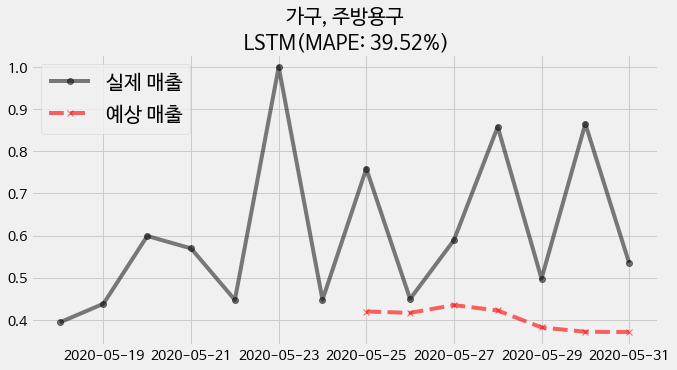

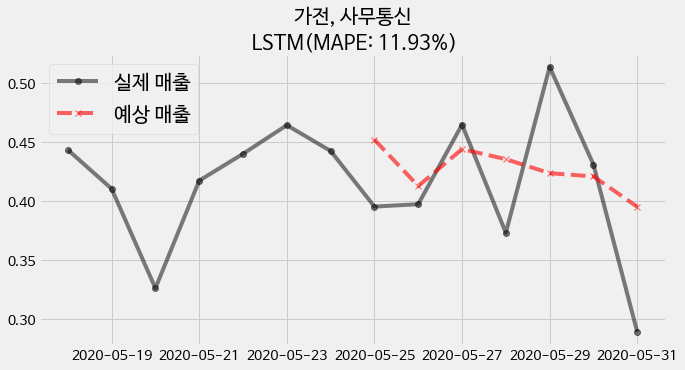

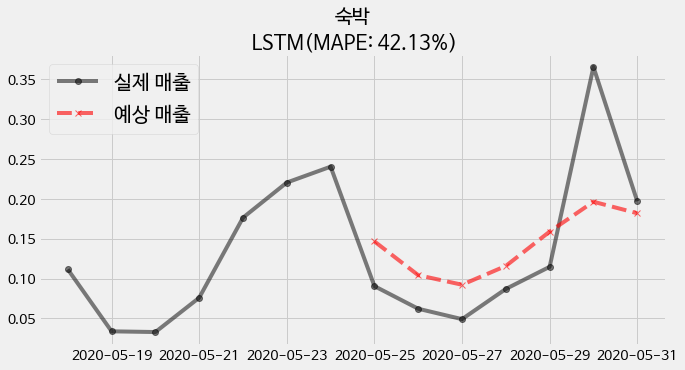

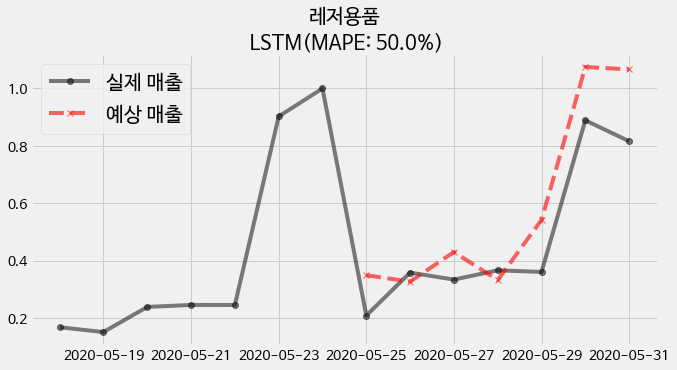

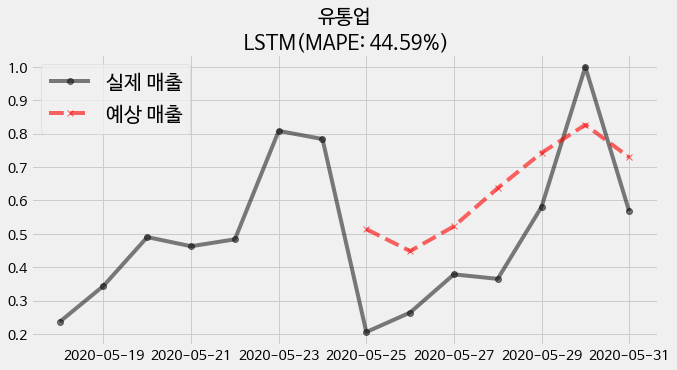

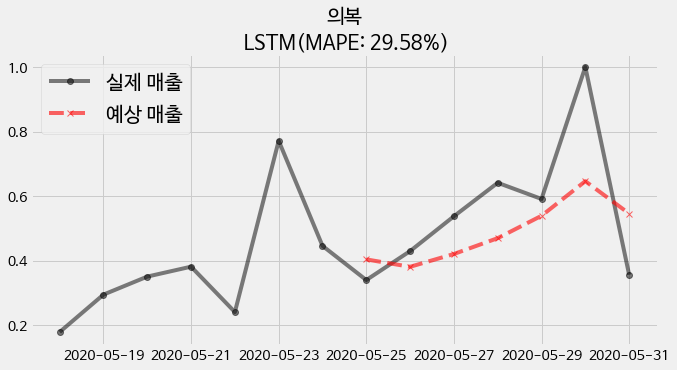

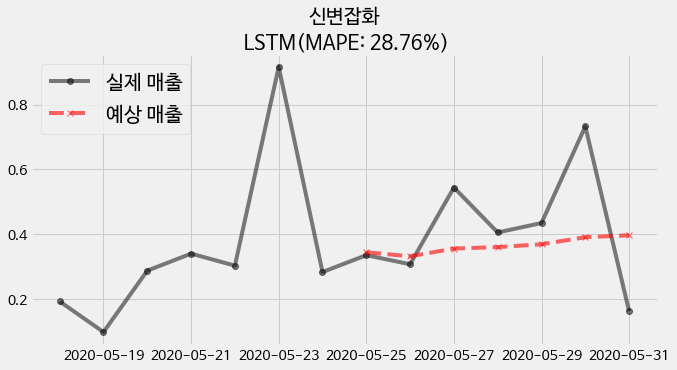

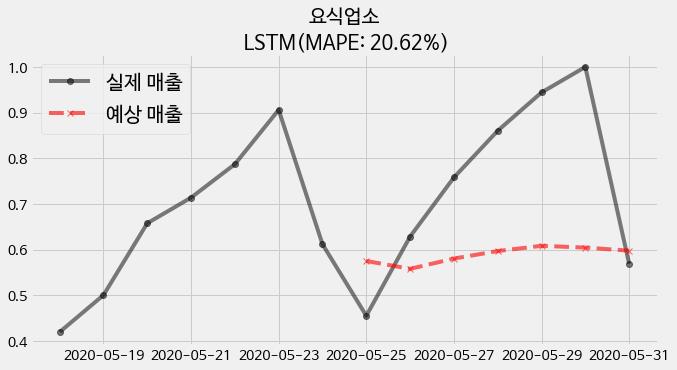

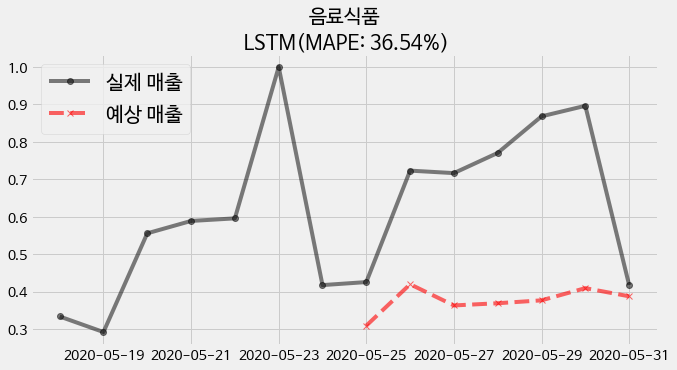

In [120]:
dates = covid.STD_DD.values[-14:]
names = ['가구, 주방용구', '가전, 사무통신', '숙박', '레저용품', '유통업', '의복', '신변잡화', '요식업소', '음료식품']

for i in range(9):
    # 5/17 ~ 5/31의 실제 매출
    real_amt = list(train_y[i]) + list(test_y[i]) 
    # 5/25 ~ 5/31 예상 매출
    pred_amt = lstm_pred[i]

    plt.figure(figsize=(10,5))
    plt.plot(dates, real_amt, marker = 'o', color = 'black', label = '실제 매출', alpha = 0.5)
    plt.plot(dates[7:], pred_amt, color = 'red', label = '예상 매출', marker = 'x', ls = '--', alpha = 0.6)
    plt.legend(loc = 'upper left', fontsize = 'x-large')
    plt.title(f"{names[i]}\n LSTM(MAPE: {round(lstm_score[i], 2)}%)", size = 20)
    plt.show()

# 3. GRU

### Train

In [127]:
class GRUModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size):
        # time model
        super(GRUModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        
        # merge model
        self.time_fc = nn.Sequential(
            nn.Linear(hidden_size, 14),
            nn.ReLU(inplace=True),
            nn.Linear(14,14),
            nn.ReLU(inplace=True),
            nn.Linear(14,7)
        )

    def forward(self, x_time):
        # time part
        # hidden = (
        #     torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
        #     torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        # )
        
        out, _ = self.gru(x_time)
        out = out[:, -1, :] # GRU의 output은 모든 출력값인데 마지막 값만 받는다.
        out = self.time_fc(out.view(-1, self.hidden_size)) # 3 -> 2차원
        
        return out

In [128]:
cols = list(df[0].columns[1:])
gru_pred = []
gru_score = []
train_y, test_y = [], []

for i in tqdm(range(9)):
    # 정규화
    for col in cols:
        if col != 'news':
            scaler = MinMaxScaler(feature_range = (0, 1))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2
        else:
            scaler = MinMaxScaler(feature_range = (-0.5, 0.5))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2

    X, y = preprocessing(df[i])
    X2, y2 = preprocessing(df2[i])

    # 2019, 2020 합치기
    X = np.concatenate([X, X2])
    y = np.concatenate([y, y2])

    X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]

    train_y.append(y_train[-1]) # 5/17 ~ 5/24
    test_y.append(y_test[-1]) # 5/25 ~ 5/31

    X = torch.FloatTensor(X_train).to(device)
    y = torch.FloatTensor(y_train).to(device)

    # hidden state : 전달과정 중간 출력의 차원
    model_trend = GRUModel_trend(input_size = 4, hidden_size = 32).to(device)
    optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
    criterion = nn.MSELoss(size_average = True)

    # Train model
    num_epochs  = 200
    hist = np.zeros(num_epochs)

    # Number of steps to unroll
    look_back = 7
    seq_dim =look_back - 1

    for t in range(num_epochs):
        pred = model_trend(X)
        loss = criterion(pred, y)

        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_pred = model_trend(torch.FloatTensor(X_test).to(device))
    gru_pred.append(y_pred[-1].cpu().detach().numpy()) # 각 카테고리의 Prediction 값(마지막 주)
    gru_score.append(mean_absolute_percentage_error(y_test, y_pred.cpu().detach().numpy())) # 각 카테고리의 Test Score

    del X, y
    gc.collect()


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch  10 MSE:  0.04406996816396713
Epoch  20 MSE:  0.03314226493239403
Epoch  30 MSE:  0.030390238389372826
Epoch  40 MSE:  0.028649205341935158
Epoch  50 MSE:  0.028284724801778793
Epoch  60 MSE:  0.028055289760231972
Epoch  70 MSE:  0.027957789599895477
Epoch  80 MSE:  0.027837757021188736
Epoch  90 MSE:  0.027719348669052124
Epoch  100 MSE:  0.02757272496819496
Epoch  110 MSE:  0.02736804634332657
Epoch  120 MSE:  0.02709837257862091
Epoch  130 MSE:  0.026486532762646675
Epoch  140 MSE:  0.025858810171484947
Epoch  150 MSE:  0.025553058832883835
Epoch  160 MSE:  0.02491498738527298
Epoch  170 MSE:  0.024502180516719818
Epoch  180 MSE:  0.024067213758826256
Epoch  190 MSE:  0.023606594651937485



 11%|█         | 1/9 [00:00<00:06,  1.20it/s]

Epoch  10 MSE:  0.033242177218198776
Epoch  20 MSE:  0.02800939418375492
Epoch  30 MSE:  0.022313160821795464
Epoch  40 MSE:  0.018962189555168152
Epoch  50 MSE:  0.017661912366747856
Epoch  60 MSE:  0.01726546511054039
Epoch  70 MSE:  0.01687818579375744
Epoch  80 MSE:  0.016529640182852745
Epoch  90 MSE:  0.016211235895752907
Epoch  100 MSE:  0.015909558162093163
Epoch  110 MSE:  0.01565171778202057
Epoch  120 MSE:  0.015394186601042747
Epoch  130 MSE:  0.0152082908898592
Epoch  140 MSE:  0.015195467509329319
Epoch  150 MSE:  0.01490151509642601
Epoch  160 MSE:  0.014566119760274887
Epoch  170 MSE:  0.014191094785928726
Epoch  180 MSE:  0.01393519714474678
Epoch  190 MSE:  0.013641796074807644



 22%|██▏       | 2/9 [00:01<00:05,  1.20it/s]

Epoch  10 MSE:  0.05507807061076164
Epoch  20 MSE:  0.027663007378578186
Epoch  30 MSE:  0.02324007637798786
Epoch  40 MSE:  0.02113613858819008
Epoch  50 MSE:  0.019325407221913338
Epoch  60 MSE:  0.01717766933143139
Epoch  70 MSE:  0.015942156314849854
Epoch  80 MSE:  0.01515654381364584
Epoch  90 MSE:  0.014477523043751717
Epoch  100 MSE:  0.013726828619837761
Epoch  110 MSE:  0.01246951799839735
Epoch  120 MSE:  0.01150592602789402
Epoch  130 MSE:  0.00903109461069107
Epoch  140 MSE:  0.008264293894171715
Epoch  150 MSE:  0.007558666635304689
Epoch  160 MSE:  0.006988995708525181
Epoch  170 MSE:  0.006885693408548832
Epoch  180 MSE:  0.006200484465807676
Epoch  190 MSE:  0.0057725063525140285



 33%|███▎      | 3/9 [00:02<00:05,  1.20it/s]

Epoch  10 MSE:  0.04808998480439186
Epoch  20 MSE:  0.04150354489684105
Epoch  30 MSE:  0.03869081661105156
Epoch  40 MSE:  0.032839447259902954
Epoch  50 MSE:  0.02858084999024868
Epoch  60 MSE:  0.023288989439606667
Epoch  70 MSE:  0.017368745058774948
Epoch  80 MSE:  0.014014012180268764
Epoch  90 MSE:  0.011825221590697765
Epoch  100 MSE:  0.010981207713484764
Epoch  110 MSE:  0.009616128169000149
Epoch  120 MSE:  0.008534378372132778
Epoch  130 MSE:  0.00787320826202631
Epoch  140 MSE:  0.007224520668387413
Epoch  150 MSE:  0.006761730182915926
Epoch  160 MSE:  0.006389467511326075
Epoch  170 MSE:  0.005658761598169804
Epoch  180 MSE:  0.005516494624316692
Epoch  190 MSE:  0.005041271448135376



 44%|████▍     | 4/9 [00:03<00:04,  1.20it/s]

Epoch  10 MSE:  0.07141374796628952
Epoch  20 MSE:  0.041664451360702515
Epoch  30 MSE:  0.0326400063931942
Epoch  40 MSE:  0.03113671950995922
Epoch  50 MSE:  0.030561143532395363
Epoch  60 MSE:  0.030296990647912025
Epoch  70 MSE:  0.0301187876611948
Epoch  80 MSE:  0.029961150139570236
Epoch  90 MSE:  0.029803112149238586
Epoch  100 MSE:  0.02963430993258953
Epoch  110 MSE:  0.029428254812955856
Epoch  120 MSE:  0.02914291061460972
Epoch  130 MSE:  0.02869187667965889
Epoch  140 MSE:  0.027760978788137436
Epoch  150 MSE:  0.025441376492381096
Epoch  160 MSE:  0.023656755685806274
Epoch  170 MSE:  0.02249721810221672
Epoch  180 MSE:  0.021658258512616158
Epoch  190 MSE:  0.020842701196670532



 56%|█████▌    | 5/9 [00:04<00:03,  1.20it/s]

Epoch  10 MSE:  0.058726243674755096
Epoch  20 MSE:  0.035008035600185394
Epoch  30 MSE:  0.02324470318853855
Epoch  40 MSE:  0.02021987922489643
Epoch  50 MSE:  0.01887306571006775
Epoch  60 MSE:  0.018681561574339867
Epoch  70 MSE:  0.01846211403608322
Epoch  80 MSE:  0.018354065716266632
Epoch  90 MSE:  0.018246537074446678
Epoch  100 MSE:  0.018150510266423225
Epoch  110 MSE:  0.01806057244539261
Epoch  120 MSE:  0.017966212704777718
Epoch  130 MSE:  0.017853837460279465
Epoch  140 MSE:  0.017732638865709305
Epoch  150 MSE:  0.01759016327559948
Epoch  160 MSE:  0.017356950789690018
Epoch  170 MSE:  0.01700351946055889
Epoch  180 MSE:  0.01653984934091568
Epoch  190 MSE:  0.015526864677667618



 67%|██████▋   | 6/9 [00:05<00:02,  1.20it/s]

Epoch  10 MSE:  0.07890474051237106
Epoch  20 MSE:  0.0364781990647316
Epoch  30 MSE:  0.032738097012043
Epoch  40 MSE:  0.02713182382285595
Epoch  50 MSE:  0.023861849680542946
Epoch  60 MSE:  0.02288389392197132
Epoch  70 MSE:  0.021833578124642372
Epoch  80 MSE:  0.021224861964583397
Epoch  90 MSE:  0.02071980945765972
Epoch  100 MSE:  0.02031712792813778
Epoch  110 MSE:  0.01998031698167324
Epoch  120 MSE:  0.01965528354048729
Epoch  130 MSE:  0.019289128482341766
Epoch  140 MSE:  0.018930763006210327
Epoch  150 MSE:  0.018850620836019516
Epoch  160 MSE:  0.018397677689790726
Epoch  170 MSE:  0.018065428361296654
Epoch  180 MSE:  0.01819906197488308
Epoch  190 MSE:  0.01768322102725506



 78%|███████▊  | 7/9 [00:05<00:01,  1.20it/s]

Epoch  10 MSE:  0.08938504010438919
Epoch  20 MSE:  0.04352427273988724
Epoch  30 MSE:  0.0331118181347847
Epoch  40 MSE:  0.0273494403809309
Epoch  50 MSE:  0.02562001906335354
Epoch  60 MSE:  0.024442793801426888
Epoch  70 MSE:  0.0236654095351696
Epoch  80 MSE:  0.022963164374232292
Epoch  90 MSE:  0.02206559292972088
Epoch  100 MSE:  0.02107369899749756
Epoch  110 MSE:  0.020393215119838715
Epoch  120 MSE:  0.019474033266305923
Epoch  130 MSE:  0.018784789368510246
Epoch  140 MSE:  0.017893537878990173
Epoch  150 MSE:  0.01717451401054859
Epoch  160 MSE:  0.016625557094812393
Epoch  170 MSE:  0.016124915331602097
Epoch  180 MSE:  0.015348367393016815
Epoch  190 MSE:  0.013917164877057076



 89%|████████▉ | 8/9 [00:06<00:00,  1.21it/s]

Epoch  10 MSE:  0.027721194550395012
Epoch  20 MSE:  0.02095615305006504
Epoch  30 MSE:  0.018995841965079308
Epoch  40 MSE:  0.01863974891602993
Epoch  50 MSE:  0.018399657681584358
Epoch  60 MSE:  0.01829802431166172
Epoch  70 MSE:  0.018247632309794426
Epoch  80 MSE:  0.018157407641410828
Epoch  90 MSE:  0.018034949898719788
Epoch  100 MSE:  0.01784096658229828
Epoch  110 MSE:  0.01768459752202034
Epoch  120 MSE:  0.01754801720380783
Epoch  130 MSE:  0.01743141934275627
Epoch  140 MSE:  0.017344871535897255
Epoch  150 MSE:  0.017197340726852417
Epoch  160 MSE:  0.017088476568460464
Epoch  170 MSE:  0.016874805092811584
Epoch  180 MSE:  0.01670161820948124
Epoch  190 MSE:  0.016766276210546494



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


### Prediction

In [129]:
gru_score

[37.435430933571126,
 23.168807439739144,
 47.431530963975874,
 36.925696002436624,
 48.16098336594931,
 25.271961063093016,
 31.254480627264016,
 14.084992094403304,
 32.10873313746558]

### 시각화

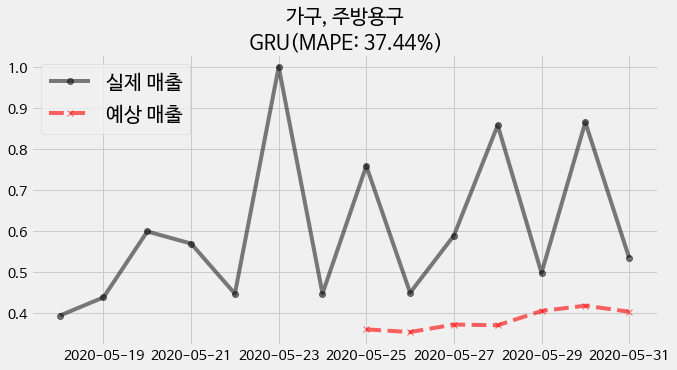

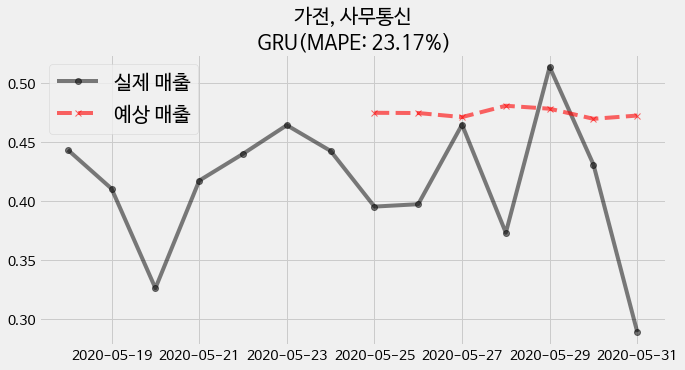

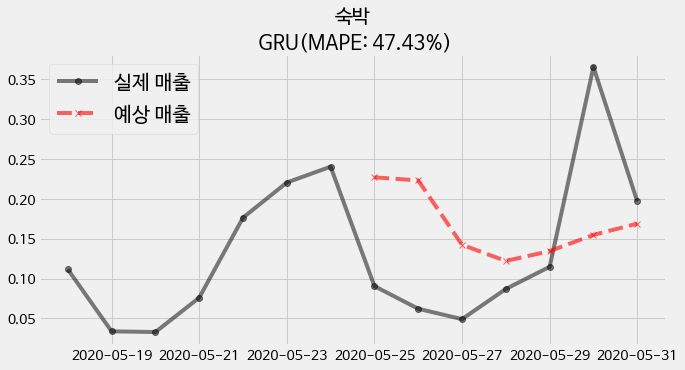

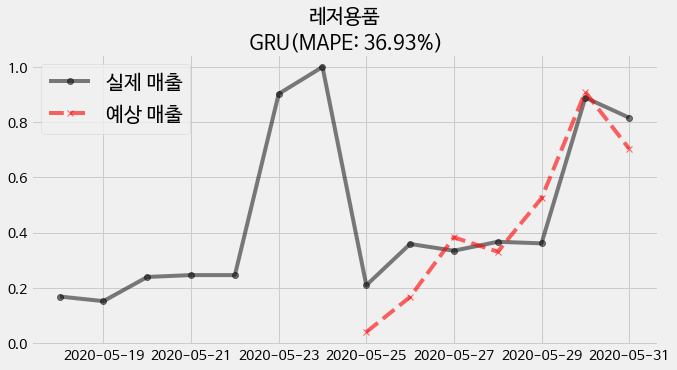

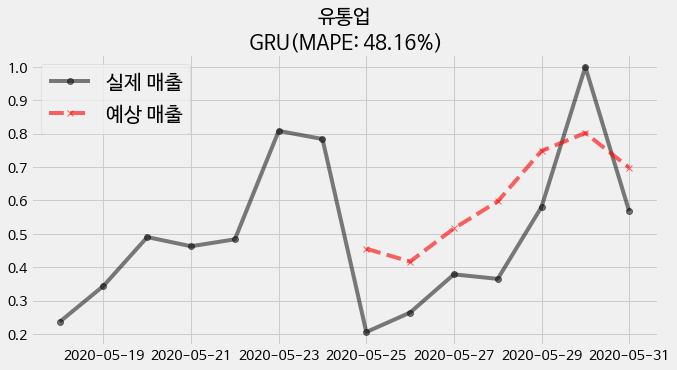

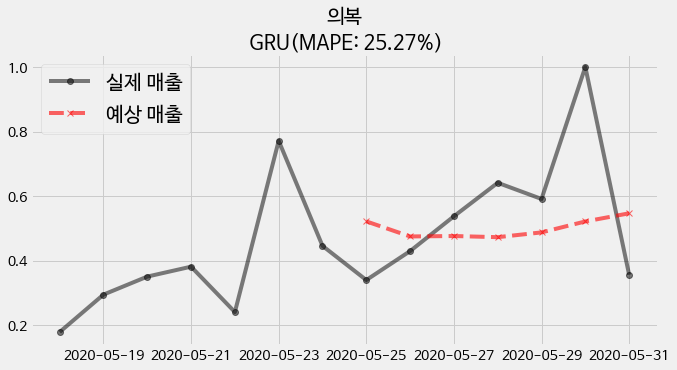

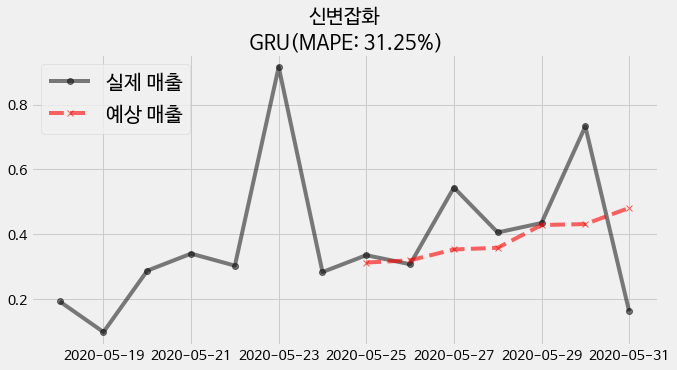

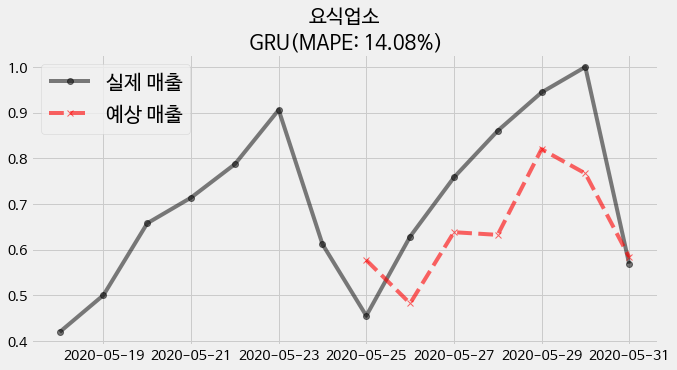

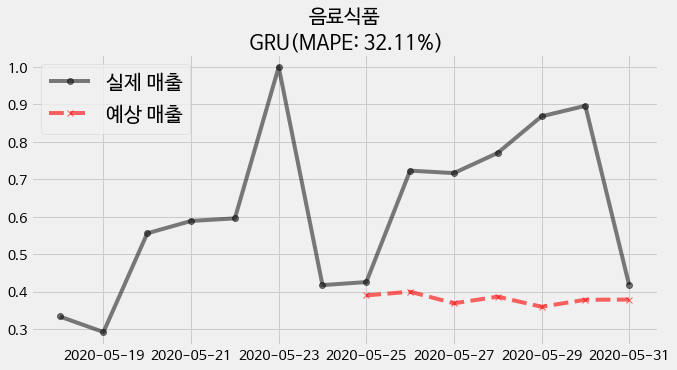

In [131]:
dates = covid.STD_DD.values[-14:]
names = ['가구, 주방용구', '가전, 사무통신', '숙박', '레저용품', '유통업', '의복', '신변잡화', '요식업소', '음료식품']

for i in range(9):
    # 5/17 ~ 5/31의 실제 매출
    real_amt = list(train_y[i]) + list(test_y[i]) 
    # 5/25 ~ 5/31 예상 매출
    pred_amt = gru_pred[i]

    plt.figure(figsize=(10,5))
    plt.plot(dates, real_amt, marker = 'o', color = 'black', label = '실제 매출', alpha = 0.5)
    plt.plot(dates[7:], pred_amt, color = 'red', label = '예상 매출', marker = 'x', ls = '--', alpha = 0.6)
    plt.legend(loc = 'upper left', fontsize = 'x-large')
    plt.title(f"{names[i]}\n GRU(MAPE: {round(gru_score[i], 2)}%)", size = 20)
    plt.show()

# 각 카테고리별 모델 비교
- XGBoost의 성능이 월등히 좋습니다.

In [132]:
pd.DataFrame({'category': names,
              'XGBoost': xgb_score,
              'LSTM': lstm_score,
              'GRU': gru_score})

,category,XGBoost,LSTM,GRU
0,"가구, 주방용구",29.653663,39.523388,37.435431
1,"가전, 사무통신",13.287071,11.927948,23.168807
2,숙박,19.473656,42.130089,47.431531
3,레저용품,25.602629,50.003496,36.925696
4,유통업,13.342098,44.593588,48.160983
5,의복,25.016994,29.575518,25.271961
6,신변잡화,28.094266,28.761625,31.254481
7,요식업소,10.517795,20.622603,14.084992
8,음료식품,23.934881,36.539147,32.108733
